An experiemnt on using active learning rather than balancing the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import plotly.express as px
plt.style.use(['science','ieee', 'no-latex']) # set the style of the plots

from util import *

In [101]:
adult = pd.read_parquet('data/formatted_data.parquet')
adult.drop(columns=['fnlwgt', 'education-num'], inplace=True) # dropping these columns
train = adult[adult['set'] == 'train'].drop(columns=['set'])
test = adult[adult['set'] == 'test'].drop(columns=['set'])
print(f'Train shape: {train.shape}')
display(train.head())
print(f'Test shape: {test.shape}')
display(test.head())

Train shape: (32561, 13)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Test shape: (16281, 13)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
# %%capture
from modAL.models import ActiveLearner
from scipy.sparse import csr_matrix

stepSize = 100

train_ = dfCategoryLimit(train, 42) # I accidentally used 42 as the max, but it is actually 43. The transformed data is only one column off, so it doesn't matter.
XTrain, YTrain, XTest, YTest = XYSplit(train_, test)
preprocessor = getPreprocessor().fit(XTrain)
XTrainTrans = preprocessor.transform(XTrain) # transform the training data
XTestTrans = preprocessor.transform(XTest) # transform the test data

startIdx = YTrain.groupby(YTrain).sample(int(stepSize/2)).index.to_numpy() # random sample from each class. Learner will start with this data

YTrain = YTrain.to_numpy()
YTest = YTest.to_numpy()

learner = ActiveLearner(
    estimator=LogisticRegression(C=10.0, solver='saga'),
    X_training=XTrainTrans[startIdx],
    y_training=YTrain[startIdx],
)

metrics = []
sizeOfDataset = [stepSize] # keep track of the size of the dataset. Alread has stepSize samples

# delete the startIdx from the training data
XTrainTrans = XTrainTrans.toarray()
XTrainTrans = np.delete(XTrainTrans, startIdx, axis=0)
XTrainTrans = csr_matrix(XTrainTrans)
YTrain = np.delete(YTrain, startIdx, axis=0)

while stepSize < XTrainTrans.shape[0]:
    # get the next sample to be queried
    query_idx, query_sample = learner.query(XTrainTrans, n_instances=stepSize)
    # teach the learner the sample
    X = XTrainTrans[query_idx]
    y = YTrain[query_idx]
    # remove the sample from the training set
    XTrainTrans = XTrainTrans.toarray()
    XTrainTrans = np.delete(XTrainTrans, query_idx, axis=0)
    XTrainTrans = csr_matrix(XTrainTrans)
    YTrain = np.delete(YTrain, query_idx)
    learner.teach(X=X, y=y)
    sizeOfDataset.append(learner.X_training.shape[0]) # keep track of the size of the dataset
    # save metrics
    metrics.append(getMetrics(learner, XTestTrans, YTest))
    print(f'Size of Active dataset: {sizeOfDataset[-1]}')


In [176]:
import pickle
results = pickle.load(open('data/logistic_results.pkl', 'rb'))
bestFromSearch = results.testMetrics.iloc[-1] # get the test metrics from the previous logistic regression search

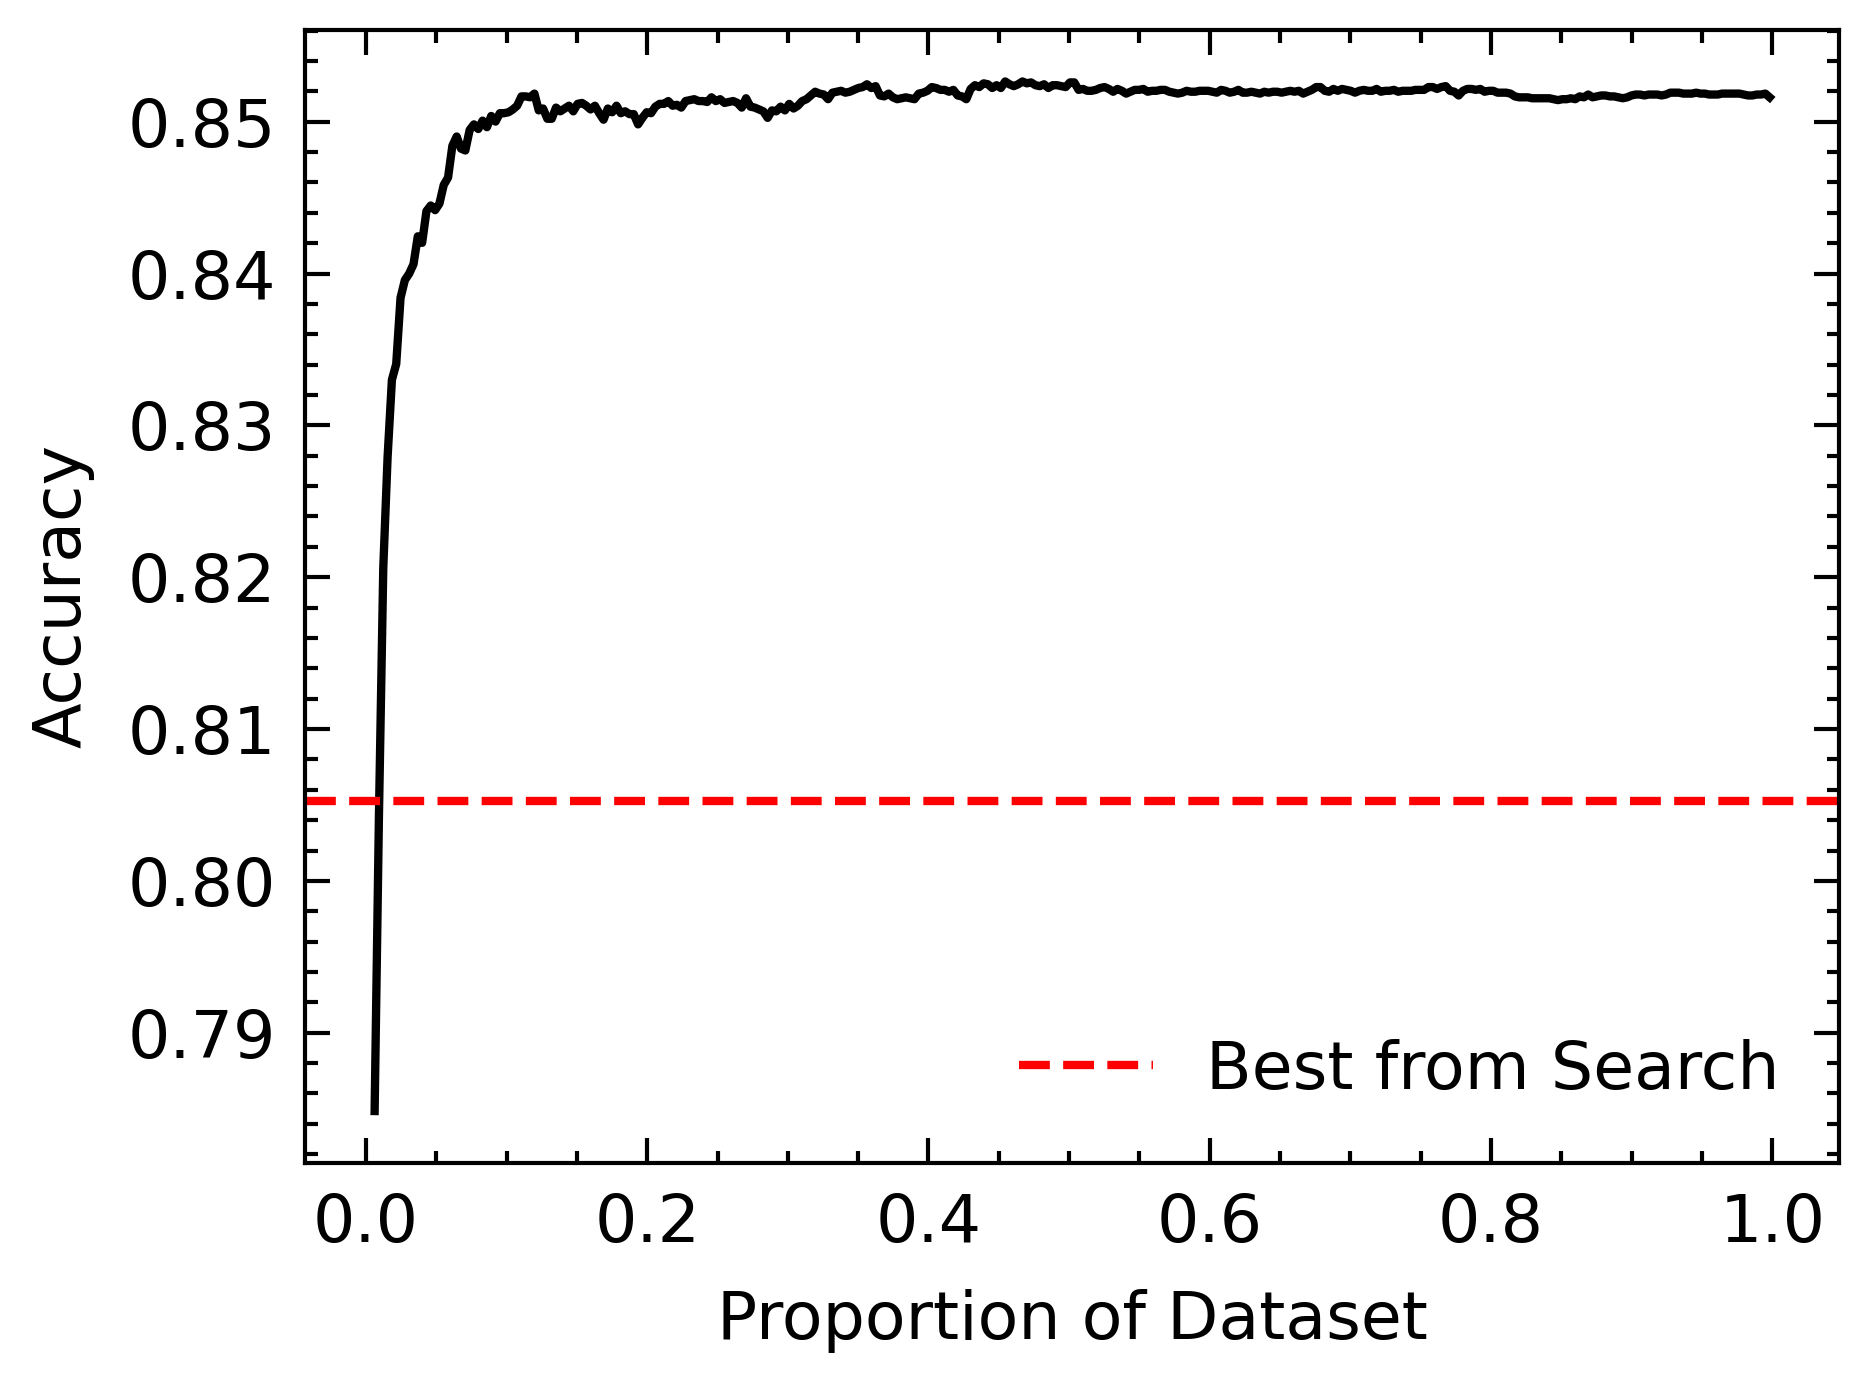

In [178]:
metric = 'accuracy'

acc = [m[metric] for m in metrics]
plt.plot(np.array(sizeOfDataset[1:]) / len(XTrain), acc)
plt.ylabel(metric.capitalize())
plt.xlabel('Proportion of Dataset')


prevBest = bestFromSearch[metric]
plt.axhline(prevBest, color='r', linestyle='--', label='Best from Search')
plt.legend()
plt.savefig(f'figures/ActiveLearning/active_learning_{metric}.png', bbox_inches='tight')

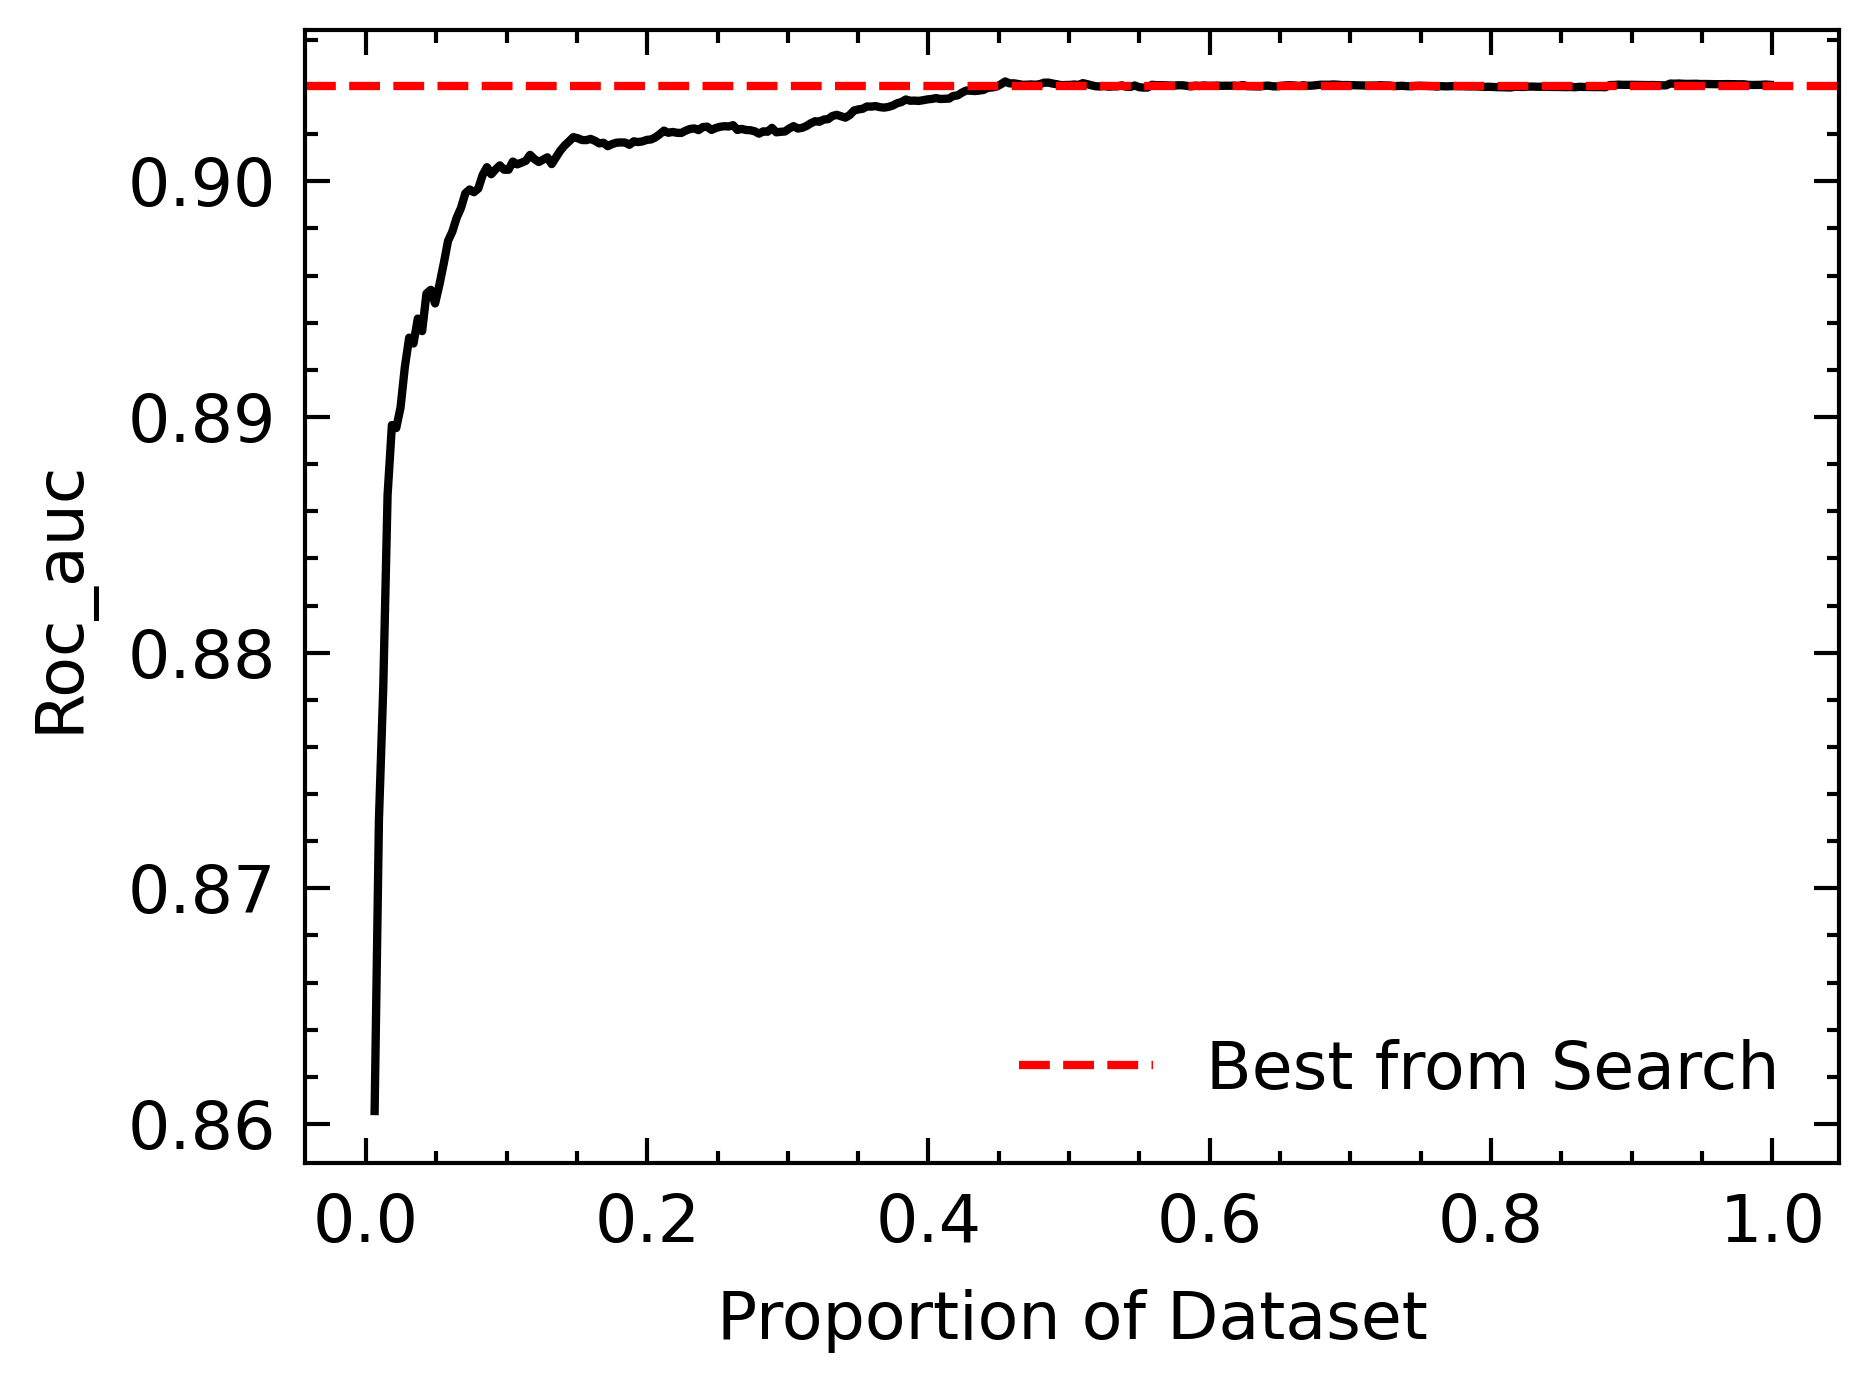

In [179]:
metric = 'roc_auc'

acc = [m[metric] for m in metrics]
plt.plot(np.array(sizeOfDataset[1:]) / len(XTrain), acc)
plt.ylabel(metric.capitalize())
plt.xlabel('Proportion of Dataset')

prevBest = bestFromSearch[metric]
plt.axhline(prevBest, color='r', linestyle='--', label='Best from Search')
plt.legend()
plt.savefig(f'figures/ActiveLearning/active_learning_{metric}.png', bbox_inches='tight')